In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
conda install lightgbm

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.0



## Package Plan ##

  environment location: /Users/susanwhite/anaconda3

  added / updated specs:
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.05.30 |       hecd8cb5_0         121 KB
    openssl-1.1.1u             |       hca72f7f_0         3.4 MB
    ------------------------------------------------------------
                                           Total:         3.5 MB

The following packages will be UPDATED:

  ca-certificates                     2023.01.10-hecd8cb5_0 --> 2023.05.30-hecd8cb5_0 

In [3]:
conda install xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [4]:
#importing necessary libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import xgboost as xgb
import math
import pickle
import joblib
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:.2f}'.format)

In [5]:
#Reading the data from files
calendar_df = pd.read_csv('calendar.csv')
sales_df = pd.read_csv('sales_train_validation.csv')
prices_df = pd.read_csv('sell_prices.csv')

In [6]:
print('shape of calendar_df is ',calendar_df.shape)
print('top 2 rows of calendar_df')
calendar_df.head(2)

shape of calendar_df is  (1969, 14)
top 2 rows of calendar_df


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0


In [7]:
print('shape of sales_df is ',sales_df.shape)
print('top 2 rows of sales_df')
sales_df.head(2)

shape of sales_df is  (30490, 1919)
top 2 rows of sales_df


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [8]:
print('shape of prices_df is ',prices_df.shape)
print('top 2 rows of prices_df')
prices_df.head(2)

shape of prices_df is  (6841121, 4)
top 2 rows of prices_df


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58


<h3>Feature Engineering </h3>

In [9]:
#reference: https://www.kaggle.com/kyakovlev/m5-simple-fe
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [10]:
#here we are inserting the columns for validation set from days d_1914 to d_1941 which we need to forecast sales as nan 
for i in range(1914,1942):
    sales_df['d_'+str(i)] = np.nan
    sales_df['d_'+str(i)] = sales_df['d_'+str(i)].astype(np.float16)

#to reduce the memory usage by changing the dtypes of columns of the dataframes
calendar_df = reduce_mem_usage(calendar_df)
prices_df = reduce_mem_usage(prices_df)
sales_df = reduce_mem_usage(sales_df)

#to transform the dataframe into vertical rows as each corresponds to each day sales of an item from a particular store
sales_melt_df = pd.melt(sales_df, id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],
                       var_name='d',value_name='sales')

#changing the dtype of object to category in order to reduce the size of dataframe
for col in sales_melt_df.columns[:6]:
    sales_melt_df[col] = sales_melt_df[col].astype('category')

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to 101.51 Mb (77.3% reduction)


In [11]:
#creating a single dataframe
sales_melt_df = sales_melt_df.merge(calendar_df,  on='d', how='left')
sales_melt_df = sales_melt_df.merge(prices_df, on=['store_id','item_id','wm_yr_wk'], how='left')

In [12]:
#pre processing missing values of prices by transforming with mean price of that id
sales_melt_df['sell_price'].fillna(sales_melt_df.groupby('id')['sell_price'].transform('mean'),inplace=True)

<h3>Lag features </h3>

In [13]:
#creating lag features such that the for a product on current day it gets it's sales upto 3 months prior.
shifting = 28 #shift period in order to account for 28 days to forecast
for i in tqdm(range(9)): #num of weeks to shift here 8 weeks we consider
    sales_melt_df['lag_'+str(shifting+(7*i))] = sales_melt_df.groupby('id')['sales'].shift(shifting+(7*i)).astype(np.float16)

100%|█████████████████████████████████████████████| 9/9 [00:22<00:00,  2.53s/it]


<h3>Rolling features </h3>

In [14]:
#creating constant shift rolling agg features
for i in tqdm([7,14,28,35,60]):
    sales_melt_df['rolling_mean_'+str(i)] =  sales_melt_df.groupby(['id'])['lag_28'].transform(lambda x: x.rolling(i).mean())
    sales_melt_df['rolling_median_'+str(i)] =  sales_melt_df.groupby(['id'])['lag_28'].transform(lambda x: x.rolling(i).median())

100%|████████████████████████████████████████████| 5/5 [11:05<00:00, 133.04s/it]


In [15]:
sales_melt_df.to_pickle("sales_melt_df") #store the dataframe into disk

In [16]:
sales_melt_df = pd.read_pickle("sales_melt_df") #load the dataframe from disk

<h3>Calender features</h3>

In [17]:
#changing dtype of calender features to category
cal_cols = ['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']
for col in cal_cols:
    sales_melt_df[col] = sales_melt_df[col].astype('category')

In [18]:
sales_melt_df['date'] = pd.to_datetime(sales_melt_df['date'])
#each day of the month
sales_melt_df['day_of_month'] = sales_melt_df['date'].dt.day.astype(np.int8)
#changing year value as 0 for 2011 and 1 for 2012 .... 5 for 2016
sales_melt_df['year'] = (sales_melt_df['year'] - sales_melt_df['year'].min()).astype(np.int8)
#week number of a day in a month ex: 29th in January corresponds to 5th week of January
sales_melt_df['week_no_inmonth'] = sales_melt_df['day_of_month'].apply(lambda x: math.ceil(x/7)).astype(np.int8)
#checking if the day is weekend or not
sales_melt_df['is_weekend'] = (sales_melt_df['wday']<=2).astype(np.int8)

In [19]:
sales_melt_df.to_pickle("sales_melt_calfadd_df") #store the final feature engineered dataframe to disk

<h3>Evaluation metric - WRMSSE</h3>

In [20]:
#https://www.kaggle.com/dhananjay3/wrmsse-evaluator-with-extra-features
#here we are transforming the 30490 timeseries into 42840 time-series by grouping based on the 12 level hirearchy
def convert_to_42840(df, cols, groupbys):
    series_gen = {}
    for i, grp in enumerate(groupbys):
        #grop by corresponding group and calculating aggregate sales of each day
        tmp = df.groupby(grp)[cols].sum()
        #storing the aggregate sale values of each corresponding group
        for j in range(len(tmp)):
            series_gen[gen_series_name(tmp.index[j])] = tmp.iloc[j].values
    return pd.DataFrame(series_gen).T #creating a dataframe of each corresponding group and aggregate sales each day i.e., transformed into 42840 sales

In [21]:
#this method return the name of each group
def gen_series_name(name):
    if isinstance(name, str) | isinstance(name, int):
        return str(name)
    else:
        return "__".join(name)

In [22]:
#here we are computing weights using the last 28 day sales of train data and their prices
def compute_weights(train_df,valid_df,weight_cols,groupbys,fix_cols):
    weights_map = {}
    weight_df = train_df[["item_id", "store_id"] + weight_cols]
    weight_df = pd.melt(weight_df,id_vars=["item_id", "store_id"],var_name='d',value_name='sales')
    weight_df = weight_df.merge(calendar_df[['wm_yr_wk','d']], on='d', how='left')
    weight_df = weight_df.merge(prices_df, how="left", on=["item_id", "store_id", "wm_yr_wk"])
    #computing dollar sales 
    weight_df["dollar_sales"] = weight_df["sales"] * weight_df["sell_price"]
    weight_df = weight_df.set_index(["item_id", "store_id", "d"]).unstack(level=2)["dollar_sales"]
    weight_df = weight_df.loc[zip(train_df.item_id, train_df.store_id), :].reset_index(drop=True)
    weight_df = pd.concat([train_df[fix_cols], weight_df],
                          axis=1, sort=False)
    #computing the weights for each group keys
    for i,grp in enumerate(groupbys):
        ser_weight = weight_df.groupby(grp)[weight_cols].sum().sum(axis=1)
        ser_weight = ser_weight / ser_weight.sum()
        for j in range(len(ser_weight)):
            weights_map[gen_series_name(ser_weight.index[j])] = np.array([ser_weight.iloc[j]])
    weights = pd.DataFrame(weights_map).T / len(groupbys) #creating a dataframe with weights corresponding to each group keys of 42840 hierachical time-series
    return weights

In [170]:
#here we compute the rmsse using the true values and predicted values along with train data which is being used to scale
#train data is used to scale the squared-error as taking the consecutive difference of each day sales
def compute_rmsse(train_df, valid_df, pred_df):
    scale_lst = []
    for i in range(len(train_df)):
        val = train_df.iloc[i].values
        # to consider the periods following the first non-zero demand observed for the series under evaluation.
        val = val[np.argmax(val!=0):]
        #to scale the squared-error as taking the consecutive difference of each day sales
        scale = ((val[1:] - val[:-1]) ** 2).mean()
        #storing the scale value corresponding to each time series
        scale_lst.append(scale)
    scale_arr = np.array(scale_lst)
    #computing mean squared error
    num = ((pred_df - valid_df)**2).mean(axis=1)
    #scaled error i.e., root mean squared scaled error
    rmsse = (num/scale_arr).map(np.sqrt)
    return rmsse

In [24]:
#here we return the final score value i.e., WRMSSE
def custom_metric(train_df, valid_df, pred_df, weights):
    #obtaing RMSSE by calling compute_rmsse function
    rmsse = compute_rmsse(train_df, valid_df, pred_df)
    #WRMSSE of each 42840 time-series is computed as product of corresponding weights and RMSSE respectively
    ser_metric = pd.concat([weights, rmsse], axis=1, sort=False).prod(axis=1)
    return np.sum(ser_metric) #aggregation of each WRMSSE of 42840 time-series to get the final WRMSSE score

<h2>Models</h2>

<h3>Forecast sales as mean sales on that weekday for the past 4 weeks </h3>

In [25]:
sales_eval_df = pd.read_csv('sales_train_evaluation.csv')

In [26]:
sales_eval_df.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0


In [27]:
groupbys = ('for_all', 'state_id', 'store_id', 'cat_id', 'dept_id',['state_id', 'cat_id'],  
            ['state_id', 'dept_id'], ['store_id', 'cat_id'],['store_id', 'dept_id'], 'item_id', 
            ['item_id', 'state_id'], ['item_id', 'store_id'])
train_df = sales_eval_df.iloc[:,:-28]
valid_df = sales_eval_df.iloc[:,-28:].copy()
train_d_cols = [col for col in train_df.columns if col.startswith('d_')]
weight_cols = train_df.iloc[:,-28:].columns.tolist()
train_df['for_all'] = "all" #for level 1 aggregation
fixed_cols = [col for col in train_df.columns if not col.startswith('d_')]
valid_d_cols = [col for col in valid_df.columns if col.startswith('d_')]
if not all([col in valid_df.columns for col in fixed_cols]):
    valid_df = pd.concat([train_df[fixed_cols],valid_df],axis=1,sort=False)
weight_df = compute_weights(train_df,valid_df,weight_cols,groupbys,fixed_cols)

In [28]:
non_d_cols = ['id','item_id','dept_id','cat_id','store_id','state_id','for_all']
d_cols = [col for col in train_df.columns if col.startswith('d_')]

In [29]:
pred_ser = []
last_28_days = d_cols[-28:]
for i in tqdm(range(len(train_df))):
    tmp_df = train_df.iloc[[i]]
    tmp_df = tmp_df.loc[:,last_28_days].T.reset_index().rename(columns={i:'sales'})
    avg_dict = {}
    pred_lst = []
    for j in range(7):
        tmp_lst = []
        for n in range(0+j,28,7):
            tmp_lst.append(n)
        avg_dict[j] = tmp_df.iloc[tmp_lst]['sales'].mean()
    for p in range(1914,1942):
        pred_lst.append(avg_dict[(p-1914)%7])
    pred_ser.append(pred_lst)

100%|████████████████████████████████████| 30490/30490 [02:22<00:00, 214.03it/s]


In [30]:
train_42840_df = convert_to_42840(train_df, train_d_cols, groupbys)
valid_42840_df = convert_to_42840(valid_df, valid_d_cols, groupbys)
predictions = np.asarray(pred_ser)
if isinstance(predictions, np.ndarray):
    predictions = pd.DataFrame(predictions, columns=valid_d_cols)
predictions = pd.concat([valid_df[fixed_cols], predictions],axis=1,sort=False)
pred_42840_df = convert_to_42840(predictions,valid_d_cols,groupbys)

In [31]:
WRMSSE = custom_metric(train_42840_df,valid_42840_df,pred_42840_df,weight_df)

In [32]:
print("WRMSSE of the model forecasted sales, as the mean sales for the past 4 weeks of that dayofweek ",WRMSSE)

WRMSSE of the model forecasted sales, as the mean sales for the past 4 weeks of that dayofweek  0.7524201372210837


In [33]:
predictions.to_csv('predictions.csv',index=False)

In [34]:
#forecasted sales from from day 1914 till 1941
predictions = pd.read_csv('predictions.csv')
predictions.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,for_all,d_1914,d_1915,d_1916,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,all,0.50,1.25,0.75,...,0.25,1.25,1.00,0.50,1.25,0.75,1.75,0.25,1.25,1.00
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,all,0.25,0.00,0.25,...,0.00,0.00,0.00,0.25,0.00,0.25,0.00,0.00,0.00,0.00


In [35]:
submit_val = predictions[['id']]
for i in range(28):
    submit_val['F'+str(i+1)] = predictions['d_'+str(1914+i)]
submit_val['id'] =  submit_val['id'].apply(lambda x: x.replace('evaluation','validation'))
submit_eval = submit_val.copy()
submit_eval["id"] = submit_eval["id"].apply(lambda x: x.replace('validation','evaluation'))
naive_predictions = submit_val.append(submit_eval).reset_index(drop=True)

In [36]:
naive_predictions.to_csv("naive_predictions.csv", index=False)

<h3>Moving average model</h3>

In [37]:
def moving_average(df,alpha):
    ma_predictions = []
    n = -alpha
    f_days = 28
    for j in tqdm(range(len(df))):
        tmp_df = df.iloc[[j]]
        pred_lst = []
        for i in range(f_days):
            win = n+i
            if n == win:
                pred_lst.append(tmp_df.iloc[:,win:].T.mean().values)
            if win > n:
                pred_lst.append(np.mean(np.concatenate((tmp_df.iloc[:,win:].T.values,np.asarray(pred_lst[:i]).reshape(-1,1)),axis=0)).astype(np.float64))
        pred_lst = [float(i) for i in pred_lst]
        ma_predictions.append(pred_lst)
    return np.asarray(ma_predictions).reshape(30490,28)

In [38]:
train_df = train_df[non_d_cols+d_cols]

<h3>Hyper parameter tuning </h3>

In [39]:
hyper_params = [28,35,42,49,56]
WRMSSE_MA = {}
train_42840_df = convert_to_42840(train_df, train_d_cols, groupbys)
valid_42840_df = convert_to_42840(valid_df, valid_d_cols, groupbys)
for alpha in hyper_params:
    ma_predictions = moving_average(train_df,alpha)
    if isinstance(ma_predictions, np.ndarray):
        ma_predictions = pd.DataFrame(ma_predictions, columns=valid_d_cols)
    ma_predictions = pd.concat([valid_df[fixed_cols], ma_predictions],axis=1,sort=False)
    ma_predictions.to_csv('ma_predictions_'+str(alpha)+'.csv',index=False)
    pred_42840_df = convert_to_42840(ma_predictions,valid_d_cols,groupbys)
    WRMSSE = custom_metric(train_42840_df,valid_42840_df,pred_42840_df,weight_df)
    WRMSSE_MA[alpha] = WRMSSE

100%|█████████████████████████████████████| 30490/30490 [06:00<00:00, 84.51it/s]


In [40]:
best_WRMSSE_ma = min(WRMSSE_MA.items(), key=lambda x: x[1])
print('The best hyper parameter of Moving average model with lower WRMSEE is: ', best_WRMSSE_ma) 

The best hyper parameter of Moving average model with lower WRMSEE is:  (35, 1.0566999614858126)


In [41]:
best_alpha = best_WRMSSE_ma[0]
ma_predictions_best = pd.read_csv('ma_predictions_'+str(best_alpha)+'.csv')
ma_predictions_best.head()

,id,item_id,dept_id,cat_id,store_id,state_id,for_all,d_1914,d_1915,d_1916,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,all,1.00,1.00,0.97,...,0.98,1.01,1.01,0.98,1.01,1.04,1.07,1.07,1.07,1.02
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,all,0.17,0.18,0.18,...,0.08,0.09,0.09,0.09,0.09,0.10,0.10,0.10,0.11,0.11
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,all,0.51,0.53,0.54,...,0.71,0.73,0.75,0.77,0.80,0.82,0.81,0.78,0.75,0.74
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,all,2.17,2.12,2.15,...,2.21,2.22,2.14,2.08,2.09,2.15,2.12,2.18,2.21,2.28
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,all,1.26,1.24,1.19,...,1.28,1.31,1.32,1.33,1.31,1.35,1.36,1.37,1.35,1.36


In [42]:
submit_val = ma_predictions_best[['id']]
for i in range(28):
    submit_val['F'+str(i+1)] = ma_predictions_best['d_'+str(1914+i)]
submit_val['id'] =  submit_val['id'].apply(lambda x: x.replace('evaluation','validation'))
submit_eval = submit_val.copy()
submit_eval["id"] = submit_eval["id"].apply(lambda x: x.replace('validation','evaluation'))
moving_average_predictions = submit_val.append(submit_eval).reset_index(drop=True)

In [43]:
moving_average_predictions.to_csv("moving_average_predictions.csv", index=False)

<h2>ML Models </h2>
<h3>Random Forest</h3>

In [44]:
sales_melt_df = pd.read_pickle("sales_melt_calfadd_df")

In [45]:
sales_melt_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,rolling_median_14,rolling_mean_28,rolling_median_28,rolling_mean_35,rolling_median_35,rolling_mean_60,rolling_median_60,day_of_month,week_no_inmonth,is_weekend
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.00,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,5,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.00,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,5,1
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.00,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,5,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.00,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,5,1
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.00,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,5,1


In [46]:
#changing the dtype to category for these columns in order to process the columns with label encoding
cat_cols = ['id','item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2','snap_CA','snap_TX','snap_WI']
for col in cat_cols:
    sales_melt_df[col] = sales_melt_df[col].astype('category')

In [47]:
#method which return the label encoded columns
def label_encoding(df,cols):
    for col in cols:
        lenc = LabelEncoder()
        df[col] = lenc.fit_transform(df[col].astype(str))
    return df

In [48]:
df_enc = label_encoding(sales_melt_df,cat_cols) #transforming the categorical columns to label encoded columns
df_enc['d'] = df_enc['d'].apply(lambda x: x.split('_')[1]).astype(np.int16) #splitting the values of 'd' comlumn to take only the day number

In [49]:
#final dataframe after pre-processing and feature engineering we are taking last 2 years data to train the ML model
df_final = df_enc.loc[pd.to_datetime(df_enc['date'].dt.date) >= '2014-01-01']

<h4>Train-CV-Test split</h4>

In [50]:
train_end = 1885 #end of training
X_tr = df_final[df_final['d'] <= train_end].drop(['sales','date','weekday','wm_yr_wk'],axis=1)
y_tr = df_final[df_final['d'] <= train_end]['sales']

X_val = df_final[(df_final['d'] > train_end) & (df_final['d'] <= train_end+28)].drop(['sales','date','weekday','wm_yr_wk'],axis=1)
y_val = df_final[(df_final['d'] > train_end) & (df_final['d'] <= train_end+28)]['sales']

X_te = df_final[(df_final['d'] > train_end+28)].drop(['sales','date','weekday','wm_yr_wk'],axis=1)

In [51]:
X_tr.shape, X_val.shape, X_te.shape

((24910330, 40), (853720, 40), (853720, 40))

In [76]:
X_te

,id,item_id,dept_id,cat_id,store_id,state_id,d,wday,month,year,...,rolling_median_14,rolling_mean_28,rolling_median_28,rolling_mean_35,rolling_median_35,rolling_mean_60,rolling_median_60,day_of_month,week_no_inmonth,is_weekend
58327370,14370,1437,3,1,0,0,1914,3,4,5,...,1.00,1.04,1.00,1.06,1.00,0.98,1.00,25,4,0
58327371,14380,1438,3,1,0,0,1914,3,4,5,...,0.00,0.36,0.00,0.31,0.00,0.25,0.00,25,4,0
58327372,14390,1439,3,1,0,0,1914,3,4,5,...,0.00,0.54,0.00,0.43,0.00,0.42,0.00,25,4,0
58327373,14400,1440,3,1,0,0,1914,3,4,5,...,2.50,1.89,1.00,1.89,1.00,2.10,2.00,25,4,0
58327374,14410,1441,3,1,0,0,1914,3,4,5,...,1.00,1.11,1.00,1.09,1.00,1.13,1.00,25,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59181085,14329,1432,2,0,9,2,1941,2,5,5,...,0.00,0.21,0.00,0.17,0.00,0.25,0.00,22,4,1
59181086,14339,1433,2,0,9,2,1941,2,5,5,...,0.00,0.32,0.00,0.26,0.00,0.15,0.00,22,4,1
59181087,14349,1434,2,0,9,2,1941,2,5,5,...,0.00,0.89,0.50,0.86,0.00,1.03,1.00,22,4,1
59181088,14359,1435,2,0,9,2,1941,2,5,5,...,0.50,0.93,1.00,1.06,1.00,1.02,1.00,22,4,1


In [52]:
#storing the train,cv, test dataframes
X_tr.to_pickle('X_tr')
y_tr.to_pickle('y_tr')
X_val.to_pickle('X_val')
y_val.to_pickle('y_val')
X_te.to_pickle('X_te')

In [53]:
#loading the train,cv, test dataframes
X_tr = pd.read_pickle("X_tr")
y_tr = pd.read_pickle("y_tr")
X_val = pd.read_pickle("X_val")
y_val = pd.read_pickle("y_val")
X_te = pd.read_pickle("X_te")

In [54]:
#group-bys to group into 12-level hierarchical time series to calculate WRMSSE 
groupbys = ('for_all', 'state_id', 'store_id', 'cat_id', 'dept_id',['state_id', 'cat_id'],  
            ['state_id', 'dept_id'], ['store_id', 'cat_id'],['store_id', 'dept_id'], 'item_id', 
            ['item_id', 'state_id'], ['item_id', 'store_id'])
alpha_lst = [50,75,100,125] #hyper-params n_estimators
depth = 10 #fixing the depth hyper-param
train_df = pd.concat([sales_df.loc[:,:'state_id'],sales_df.loc[:,'d_1069':]],axis=1,sort=False)
train_df = train_df.iloc[:,:-28]
valid_df = train_df.iloc[:,-28:].copy()
train_d_cols = [col for col in train_df.columns if col.startswith('d_')]
weight_cols = train_df.iloc[:,-28:].columns.tolist()
train_df['for_all'] = "all" #for level 1 aggregation
fixed_cols = [col for col in train_df.columns if not col.startswith('d_')]
valid_d_cols = [col for col in valid_df.columns if col.startswith('d_')]
if not all([col in valid_df.columns for col in fixed_cols]):
    valid_df = pd.concat([train_df[fixed_cols],valid_df],axis=1,sort=False)
#weights corresponding all the 12-level hierarchical transformed 42840 time-series
weight_df = compute_weights(train_df,valid_df,weight_cols,groupbys,fixed_cols)
#train data transformed from 30490 timeseries to 42840 hirerachichal time-series
train_42840_df = convert_to_42840(train_df, train_d_cols, groupbys)
#validation data transformed from 30490 timeseries to 42840 hirerachichal time-series
valid_42840_df = convert_to_42840(valid_df, valid_d_cols, groupbys)

#RandomForestRegressor model training and hyperparameter tuning
WRMSSE_rf = {}
for alpha in tqdm(alpha_lst):
    rf_pred = pd.DataFrame()
    rf_reg = RandomForestRegressor(n_estimators=alpha, max_depth=depth,n_jobs=-1)
    rf_reg.fit(X_tr,y_tr)
    #predicting the sales of each day from day 1886 to day 1913 cv data
    for i in range(1886,1914):
        rf_pred['d_'+str(i)] = rf_reg.predict(X_val[X_val['d']==i])
    rf_pred = pd.concat([valid_df[fixed_cols], rf_pred],axis=1,sort=False)
    #prediction data transformed from 30490 timeseries to 42840 hirerachichal time-series
    pred_42840_df = convert_to_42840(rf_pred,valid_d_cols,groupbys)
    #Computed WRMSSE for each predictions based on hyper-parameters
    WRMSSE_rf[(alpha,depth)] = custom_metric(train_42840_df,valid_42840_df,pred_42840_df,weight_df)

100%|████████████████████████████████████████| 4/4 [10:19:30<00:00, 9292.58s/it]


In [55]:
print('WRMSSE for different number of base learners with depth=10 is:\n',WRMSSE_rf)

WRMSSE for different number of base learners with depth=10 is:
 {(50, 10): 0.6738455115680668, (75, 10): 0.673207033532121, (100, 10): 0.6738107579700731, (125, 10): 0.6735774646681627}


1. Using Random Forest model with depth=10 and n_estimators=50 we observe the lowest WRMSSE and hence we train the best model with these hyper parameters and forecast the sales for the test data.

In [56]:
pickle.dump(WRMSSE_rf, open('WRMSSE_rf', 'wb')) 

In [57]:
WRMSSE_rf = pickle.load(open('WRMSSE_rf', 'rb'))

In [58]:
print('The best hyper parameters of randomforestregressor model with lower WRMSEE is: ', min(WRMSSE_rf.items(), key=lambda x: x[1])) 

The best hyper parameters of randomforestregressor model with lower WRMSEE is:  ((75, 10), 0.673207033532121)


Training with best hyperparameters to predict sales for the test data

In [59]:
best_alpha = 75
best_d = 10

In [74]:
X_te[X_te['d']==1886]

,id,item_id,dept_id,cat_id,store_id,state_id,d,wday,month,year,...,rolling_median_14,rolling_mean_28,rolling_median_28,rolling_mean_35,rolling_median_35,rolling_mean_60,rolling_median_60,day_of_month,week_no_inmonth,is_weekend


In [96]:
sales_eval_df = pd.read_csv('sales_train_evaluation.csv') #reading eval data since we have true labels for days from 1914 till 1941
groupbys = ('for_all', 'state_id', 'store_id', 'cat_id', 'dept_id',['state_id', 'cat_id'],  
            ['state_id', 'dept_id'], ['store_id', 'cat_id'],['store_id', 'dept_id'], 'item_id', 
            ['item_id', 'state_id'], ['item_id', 'store_id'])
train_df = pd.concat([sales_eval_df.loc[:,:'state_id'],sales_eval_df.loc[:,'d_1069':]],axis=1,sort=False)
index_df = train_df.iloc[:,-28:].copy()
train_df = train_df.iloc[:,:-28]
valid_df = train_df.iloc[:,-28:].copy()
train_d_cols = [col for col in train_df.columns if col.startswith('d_')]
weight_cols = train_df.iloc[:,-28:].columns.tolist()
train_df['for_all'] = "all" #for level 1 aggregation
fixed_cols = [col for col in train_df.columns if not col.startswith('d_')]
valid_d_cols = [col for col in valid_df.columns if col.startswith('d_')]
valid_d_cols1 = [col for col in index_df.columns if col.startswith('d_')]
if not all([col in valid_df.columns for col in fixed_cols]):
    valid_df = pd.concat([train_df[fixed_cols],valid_df],axis=1,sort=False)
weight_df = compute_weights(train_df,valid_df,weight_cols,groupbys,fixed_cols)
train_42840_df = convert_to_42840(train_df, train_d_cols, groupbys)
valid_42840_df = convert_to_42840(valid_df, valid_d_cols, groupbys)

final_predictions_rf = pd.DataFrame()
#training the best model with the best hyper-parameters
rf_reg_best = RandomForestRegressor(n_estimators=best_alpha, max_depth=best_d,n_jobs=-1)
rf_reg_best.fit(X_tr,y_tr)
#forecasting sales for the test data from day 1914 to 1941
for i in range(1914,1942):
    final_predictions_rf['d_'+str(i)] = rf_reg_best.predict(X_te[X_te['d']==i])
final_predictions_rf = pd.concat([valid_df[fixed_cols], final_predictions_rf],axis=1,sort=False)
pred_42840_df = convert_to_42840(final_predictions_rf,valid_d_cols1,groupbys)
#WRMSSE of test data
WRMSSE_rf_te = custom_metric(train_42840_df,valid_42840_df,pred_42840_df,weight_df)

In [97]:
final_predictions_rf.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'for_all',
       'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920',
       'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927',
       'd_1928', 'd_1929', 'd_1930', 'd_1931', 'd_1932', 'd_1933', 'd_1934',
       'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939', 'd_1940', 'd_1941'],
      dtype='object')

In [98]:
valid_df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'for_all',
       'd_1886', 'd_1887', 'd_1888', 'd_1889', 'd_1890', 'd_1891', 'd_1892',
       'd_1893', 'd_1894', 'd_1895', 'd_1896', 'd_1897', 'd_1898', 'd_1899',
       'd_1900', 'd_1901', 'd_1902', 'd_1903', 'd_1904', 'd_1905', 'd_1906',
       'd_1907', 'd_1908', 'd_1909', 'd_1910', 'd_1911', 'd_1912', 'd_1913'],
      dtype='object')

In [99]:
valid_d_cols

['d_1886',
 'd_1887',
 'd_1888',
 'd_1889',
 'd_1890',
 'd_1891',
 'd_1892',
 'd_1893',
 'd_1894',
 'd_1895',
 'd_1896',
 'd_1897',
 'd_1898',
 'd_1899',
 'd_1900',
 'd_1901',
 'd_1902',
 'd_1903',
 'd_1904',
 'd_1905',
 'd_1906',
 'd_1907',
 'd_1908',
 'd_1909',
 'd_1910',
 'd_1911',
 'd_1912',
 'd_1913']

In [100]:
train_df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1069',
       'd_1070', 'd_1071', 'd_1072',
       ...
       'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910', 'd_1911',
       'd_1912', 'd_1913', 'for_all'],
      dtype='object', length=852)

In [101]:
print('WRMSSE on test data using randomforestregressor is: ',WRMSSE_rf_te)

WRMSSE on test data using randomforestregressor is:  0.6377966678605471


In [102]:
joblib.dump(rf_reg_best,'rf_reg_best.pkl') #storing the best model

['rf_reg_best.pkl']

In [103]:
rf_reg_best = joblib.load('rf_reg_best.pkl')

In [104]:
final_predictions_rf.to_csv('final_predictions_rf.csv',index=False)

In [105]:
#forecasted sales from from day 1914 till 1941
final_predictions_rf = pd.read_csv('final_predictions_rf.csv')
final_predictions_rf.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,for_all,d_1914,d_1915,d_1916,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,all,0.88,0.87,0.87,...,0.86,1.24,1.21,0.92,0.91,0.89,0.97,0.90,1.21,1.20
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,all,0.25,0.25,0.25,...,0.20,0.23,0.23,0.19,0.19,0.19,0.19,0.19,0.22,0.22


In [106]:
"""submit_val = final_predictions_rf[['id']]
for i in range(28):
    submit_val['F'+str(i+1)] = final_predictions_rf['d_'+str(1914+i)]
submit_val['id'] =  submit_val['id'].apply(lambda x: x.replace('evaluation','validation'))
submit_eval = submit_val.copy()
submit_eval["id"] = submit_eval["id"].apply(lambda x: x.replace('validation','evaluation'))
random_forest_predictions = submit_val.append(submit_eval).reset_index(drop=True)"""

'submit_val = final_predictions_rf[[\'id\']]\nfor i in range(28):\n    submit_val[\'F\'+str(i+1)] = final_predictions_rf[\'d_\'+str(1914+i)]\nsubmit_val[\'id\'] =  submit_val[\'id\'].apply(lambda x: x.replace(\'evaluation\',\'validation\'))\nsubmit_eval = submit_val.copy()\nsubmit_eval["id"] = submit_eval["id"].apply(lambda x: x.replace(\'validation\',\'evaluation\'))\nrandom_forest_predictions = submit_val.append(submit_eval).reset_index(drop=True)'

In [107]:
#random_forest_predictions.to_csv("random_forest_predictions.csv", index=False)

<h3>LightGbm Model</h3>

In [111]:
#group-bys to group into 12-level hierarchical time series to calculate WRMSSE 
groupbys = ('for_all', 'state_id', 'store_id', 'cat_id', 'dept_id',['state_id', 'cat_id'],  
            ['state_id', 'dept_id'], ['store_id', 'cat_id'],['store_id', 'dept_id'], 'item_id', 
            ['item_id', 'state_id'], ['item_id', 'store_id'])
alpha_lst = [50,75,100,125] #hyper-params num_leaves
lr_lst = [0.025,0.05,0.075] #hyper-params learning_rate
train_df = pd.concat([sales_df.loc[:,:'state_id'],sales_df.loc[:,'d_1069':]],axis=1,sort=False)
index_df = train_df.iloc[:,-28:].copy()
train_df = train_df.iloc[:,:-28]
valid_df = train_df.iloc[:,-28:].copy()
train_d_cols = [col for col in train_df.columns if col.startswith('d_')]
weight_cols = train_df.iloc[:,-28:].columns.tolist()
train_df['for_all'] = "all" #for level 1 aggregation
fixed_cols = [col for col in train_df.columns if not col.startswith('d_')]
valid_d_cols = [col for col in valid_df.columns if col.startswith('d_')]

if not all([col in valid_df.columns for col in fixed_cols]):
    valid_df = pd.concat([train_df[fixed_cols],valid_df],axis=1,sort=False)
#weights corresponding all the 12-level hierarchical transformed 42840 time-series
weight_df = compute_weights(train_df,valid_df,weight_cols,groupbys,fixed_cols)
#train data transformed from 30490 timeseries to 42840 hirerachichal time-series
train_42840_df = convert_to_42840(train_df, train_d_cols, groupbys)
#validation data transformed from 30490 timeseries to 42840 hirerachichal time-series
valid_42840_df = convert_to_42840(valid_df, valid_d_cols, groupbys)

#LGBMRegressor model training and hyperparameter tuning
WRMSSE_lgb = {}
for alpha in tqdm(alpha_lst):
    for lr in tqdm(lr_lst):
        lgb_pred = pd.DataFrame()
        lgb_reg = lgb.LGBMRegressor(num_leaves=alpha,n_estimators=100,learning_rate=lr,n_jobs=-1)
        lgb_reg.fit(X_tr,y_tr) #fit the model
        #predicting the sales of each day from day 1886 to day 1913 cv data
        for i in range(1886,1914):
            lgb_pred['d_'+str(i)] = lgb_reg.predict(X_val[X_val['d']==i])
        lgb_pred = pd.concat([valid_df[fixed_cols], lgb_pred],axis=1,sort=False)
        #prediction data transformed from 30490 timeseries to 42840 hirerachichal time-series
        pred_42840_df = convert_to_42840(lgb_pred,valid_d_cols,groupbys)
        #Computed WRMSSE for each predictions based on hyper-parameters
        WRMSSE_lgb[(alpha,lr)] = custom_metric(train_42840_df,valid_42840_df,pred_42840_df,weight_df)

100%|████████████████████████████████████████████| 4/4 [38:15<00:00, 573.85s/it]


In [112]:
pickle.dump(WRMSSE_lgb, open('WRMSSE_lgb', 'wb'))

In [113]:
print('WRMSSE for different num_leaves and learning_rate for lgbmregressor model is:\n',WRMSSE_lgb)

WRMSSE for different num_leaves and learning_rate for lgbmregressor model is:
 {(50, 0.025): 0.8075553879596885, (50, 0.05): 0.6436074339169913, (50, 0.075): 0.5991414850176814, (75, 0.025): 0.7828093856800569, (75, 0.05): 0.6235652005566088, (75, 0.075): 0.588889787995105, (100, 0.025): 0.7670885201798677, (100, 0.05): 0.6163764286631515, (100, 0.075): 0.5862138636053861, (125, 0.025): 0.7540410398076174, (125, 0.05): 0.6046201678928438, (125, 0.075): 0.5849896346083583}


In [114]:
print('The best hyper parameters of lgbmregressor model with lower WRMSEE is: ', min(WRMSSE_lgb.items(), key=lambda x: x[1])) 

The best hyper parameters of lgbmregressor model with lower WRMSEE is:  ((125, 0.075), 0.5849896346083583)


Training with best hyperparameters to predict sales for the test data

In [115]:
sales_eval_df = pd.read_csv('sales_train_evaluation.csv') #reading eval data since we have true labels for days from 1914 till 1941
groupbys = ('for_all', 'state_id', 'store_id', 'cat_id', 'dept_id',['state_id', 'cat_id'],  
            ['state_id', 'dept_id'], ['store_id', 'cat_id'],['store_id', 'dept_id'], 'item_id', 
            ['item_id', 'state_id'], ['item_id', 'store_id'])
train_df = pd.concat([sales_eval_df.loc[:,:'state_id'],sales_eval_df.loc[:,'d_1069':]],axis=1,sort=False)
train_df = train_df.iloc[:,:-28]
valid_df = train_df.iloc[:,-28:].copy()
train_d_cols = [col for col in train_df.columns if col.startswith('d_')]
weight_cols = train_df.iloc[:,-28:].columns.tolist()
train_df['for_all'] = "all" #for level 1 aggregation
fixed_cols = [col for col in train_df.columns if not col.startswith('d_')]
valid_d_cols = [col for col in valid_df.columns if col.startswith('d_')]
valid_d_cols1 = [col for col in index_df.columns if col.startswith('d_')]
if not all([col in valid_df.columns for col in fixed_cols]):
    valid_df = pd.concat([train_df[fixed_cols],valid_df],axis=1,sort=False)
weight_df = compute_weights(train_df,valid_df,weight_cols,groupbys,fixed_cols)
train_42840_df = convert_to_42840(train_df, train_d_cols, groupbys)
valid_42840_df = convert_to_42840(valid_df, valid_d_cols, groupbys)

alpha = 125
lr = 0.075
final_predictions_lgb = pd.DataFrame()
#training the best model with the best hyper-parameters
lgb_reg_best = lgb.LGBMRegressor(num_leaves=alpha,n_estimators=100,learning_rate=lr,n_jobs=-1)
lgb_reg_best.fit(X_tr,y_tr) #fit the model
#forecasting sales for the test data from day 1914 to 1941 test data
for i in range(1914,1942):
    final_predictions_lgb['d_'+str(i)] = lgb_reg_best.predict(X_te[X_te['d']==i])
final_predictions_lgb = pd.concat([valid_df[fixed_cols], final_predictions_lgb],axis=1,sort=False)
pred_42840_df = convert_to_42840(final_predictions_lgb,valid_d_cols1,groupbys)
#WRMSSE of test data
WRMSSE_lgb_te = custom_metric(train_42840_df,valid_42840_df,pred_42840_df,weight_df)

In [116]:
print('WRMSSE on test data using lgbmregressor is: ',WRMSSE_lgb_te)

WRMSSE on test data using lgbmregressor is:  0.5899743276051983


In [117]:
joblib.dump(lgb_reg_best,'lgb_reg_best.pkl') #store the best model

['lgb_reg_best.pkl']

In [118]:
lgb_reg_best = joblib.load('lgb_reg_best.pkl')

In [121]:
final_predictions_lgb.to_csv('final_predictions_lgb.csv',index=False)
final_predictions_lgb.head()

,id,item_id,dept_id,cat_id,store_id,state_id,for_all,d_1914,d_1915,d_1916,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,all,0.98,0.87,0.84,...,0.89,1.38,1.25,0.99,0.90,0.86,1.01,0.90,1.27,1.22
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,all,0.36,0.29,0.29,...,0.21,0.28,0.27,0.19,0.17,0.19,0.17,0.21,0.29,0.29
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,all,0.40,0.37,0.37,...,0.54,0.68,0.79,0.63,0.60,0.65,0.56,0.63,0.81,0.83
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,all,1.92,1.67,1.66,...,1.62,2.07,2.29,1.74,1.55,1.48,1.43,1.71,2.56,2.51
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,all,0.96,0.88,1.04,...,1.03,1.32,1.35,0.93,0.90,0.90,0.98,1.06,1.44,1.64


In [124]:
#forecasted sales from from day 1914 till 1941 test data
final_predictions_lgb = pd.read_csv('final_predictions_lgb.csv')
final_predictions_lgb.head()

,id,item_id,dept_id,cat_id,store_id,state_id,for_all,d_1914,d_1915,d_1916,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,all,0.98,0.87,0.84,...,0.89,1.38,1.25,0.99,0.90,0.86,1.01,0.90,1.27,1.22
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,all,0.36,0.29,0.29,...,0.21,0.28,0.27,0.19,0.17,0.19,0.17,0.21,0.29,0.29
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,all,0.40,0.37,0.37,...,0.54,0.68,0.79,0.63,0.60,0.65,0.56,0.63,0.81,0.83
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,all,1.92,1.67,1.66,...,1.62,2.07,2.29,1.74,1.55,1.48,1.43,1.71,2.56,2.51
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,all,0.96,0.88,1.04,...,1.03,1.32,1.35,0.93,0.90,0.90,0.98,1.06,1.44,1.64


In [ ]:
submit_val = final_predictions_lgb[['id']]
for i in range(28):
    submit_val['F'+str(i+1)] = final_predictions_lgb['d_'+str(1914+i)]
submit_val['id'] =  submit_val['id'].apply(lambda x: x.replace('evaluation','validation'))
submit_eval = submit_val.copy()
submit_eval["id"] = submit_eval["id"].apply(lambda x: x.replace('validation','evaluation'))
submit_lgb = submit_val.append(submit_eval).reset_index(drop=True)

In [ ]:
submit_lgb.to_csv("submit_lgb.csv", index=False)

<h3>Linear model - SGDRegressor with squared loss</h3>

In [125]:
scalar = StandardScaler()
X_tr_scaled = scalar.fit_transform(X_tr)
X_val_scaled = scalar.fit_transform(X_val)
X_te_scaled = scalar.fit_transform(X_te)

In [127]:
#group-bys to group into 12-level hierarchical time series to calculate WRMSSE 
groupbys = ('for_all', 'state_id', 'store_id', 'cat_id', 'dept_id',['state_id', 'cat_id'],  
            ['state_id', 'dept_id'], ['store_id', 'cat_id'],['store_id', 'dept_id'], 'item_id', 
            ['item_id', 'state_id'], ['item_id', 'store_id'])
alpha_lst = [0.0001,0.001,0.01,0.1,0.5,0.7,1] #hyper-param constant that multiplies the regularization term
train_df = pd.concat([sales_df.loc[:,:'state_id'],sales_df.loc[:,'d_1069':]],axis=1,sort=False)
train_df = train_df.iloc[:,:-28]
valid_df = train_df.iloc[:,-28:].copy()
train_d_cols = [col for col in train_df.columns if col.startswith('d_')]
weight_cols = train_df.iloc[:,-28:].columns.tolist()
train_df['for_all'] = "all" #for level 1 aggregation
fixed_cols = [col for col in train_df.columns if not col.startswith('d_')]
valid_d_cols = [col for col in valid_df.columns if col.startswith('d_')]
if not all([col in valid_df.columns for col in fixed_cols]):
    valid_df = pd.concat([train_df[fixed_cols],valid_df],axis=1,sort=False)
#weights corresponding all the 12-level hierarchical transformed 42840 time-series
weight_df = compute_weights(train_df,valid_df,weight_cols,groupbys,fixed_cols)
#train data transformed from 30490 timeseries to 42840 hirerachichal time-series
train_42840_df = convert_to_42840(train_df, train_d_cols, groupbys)
#validation data transformed from 30490 timeseries to 42840 hirerachichal time-series
valid_42840_df = convert_to_42840(valid_df, valid_d_cols, groupbys)

#SGDRegressor model training and hyperparameter tuning
WRMSSE_sgd = {}
for alpha in tqdm(alpha_lst):
    sgdreg = SGDRegressor(alpha=alpha,loss='squared_error',early_stopping=True)
    sgdreg.fit(X_tr_scaled,y_tr.values)
    sgd_predictions = sgdreg.predict(X_val_scaled)
    
    #slicing the predictions such that to get each day predictions of all the products of cv data
    start = 0
    t = int(X_val.iloc[0]['d'])
    sgd_pred_df = pd.DataFrame()
    while start < len(sgd_predictions):
        end = start + 30490
        sgd_pred_df['d_'+str(t)] = sgd_predictions[start:end]
        start = end
        t = t+1
    sgd_pred_df = pd.concat([valid_df[fixed_cols], sgd_pred_df],axis=1,sort=False)
    #prediction data transformed from 30490 timeseries to 42840 hirerachichal time-series
    pred_42840_df = convert_to_42840(sgd_pred_df,valid_d_cols,groupbys)
    #Computed WRMSSE for each predictions based on hyper-parameters
    WRMSSE_sgd[alpha] = custom_metric(train_42840_df,valid_42840_df,pred_42840_df,weight_df)

100%|████████████████████████████████████████████| 7/7 [23:44<00:00, 203.55s/it]


In [128]:
print('WRMSSE for different learning_rate of SGDRegressor model is:\n',WRMSSE_sgd)

WRMSSE for different learning_rate of SGDRegressor model is:
 {0.0001: 0.8477923441603323, 0.001: 0.8477516869688723, 0.01: 1.2227306926098842, 0.1: 1.0519619779454832, 0.5: 0.9365501662754815, 0.7: 1.0057632829015535, 1: 1.049228986312951}


In [129]:
pickle.dump(WRMSSE_sgd, open('WRMSSE_sgd', 'wb'))

In [130]:
print('The best hyper parameters of SGDRegressor model with lower WRMSEE is: ', min(WRMSSE_sgd.items(), key=lambda x: x[1])) 

The best hyper parameters of SGDRegressor model with lower WRMSEE is:  (0.001, 0.8477516869688723)


##### Training with best hyperparameters to predict sales for the test data

In [132]:
sales_eval_df = pd.read_csv('sales_train_evaluation.csv') #reading eval data since we have true labels for days from 1914 till 1941
groupbys = ('for_all', 'state_id', 'store_id', 'cat_id', 'dept_id',['state_id', 'cat_id'],  
            ['state_id', 'dept_id'], ['store_id', 'cat_id'],['store_id', 'dept_id'], 'item_id', 
            ['item_id', 'state_id'], ['item_id', 'store_id'])
train_df = pd.concat([sales_eval_df.loc[:,:'state_id'],sales_eval_df.loc[:,'d_1069':]],axis=1,sort=False)
train_df = train_df.iloc[:,:-28]
valid_df = train_df.iloc[:,-28:].copy()
train_d_cols = [col for col in train_df.columns if col.startswith('d_')]
weight_cols = train_df.iloc[:,-28:].columns.tolist()
train_df['for_all'] = "all" #for level 1 aggregation
fixed_cols = [col for col in train_df.columns if not col.startswith('d_')]
valid_d_cols = [col for col in valid_df.columns if col.startswith('d_')]
valid_d_cols1 = [col for col in index_df.columns if col.startswith('d_')]
if not all([col in valid_df.columns for col in fixed_cols]):
    valid_df = pd.concat([train_df[fixed_cols],valid_df],axis=1,sort=False)
weight_df = compute_weights(train_df,valid_df,weight_cols,groupbys,fixed_cols)
train_42840_df = convert_to_42840(train_df, train_d_cols, groupbys)
valid_42840_df = convert_to_42840(valid_df, valid_d_cols, groupbys)

#training the best model with the best hyper-parameters
best_alpha = 0.1
sgdreg = SGDRegressor(alpha=best_alpha,loss='squared_error',early_stopping=True)
sgdreg.fit(X_tr_scaled,y_tr.values)
sgd_predictions = sgdreg.predict(X_te_scaled)

#slicing the predictions such that to get each day predictions of all the products of test data
start = 0
t = int(X_te.iloc[0]['d'])
sgd_pred_df = pd.DataFrame()
while start < len(sgd_predictions):
    end = start + 30490
    sgd_pred_df['d_'+str(t)] = sgd_predictions[start:end]
    start = end
    t = t+1
sgd_pred_df = pd.concat([valid_df[fixed_cols], sgd_pred_df],axis=1,sort=False)
#prediction data transformed from 30490 timeseries to 42840 hirerachichal time-series
pred_42840_df = convert_to_42840(sgd_pred_df,valid_d_cols1,groupbys)
#Computed WRMSSE for each predictions based on hyper-parameters
WRMSSE_sgd_te = custom_metric(train_42840_df,valid_42840_df,pred_42840_df,weight_df)

In [133]:
print('WRMSSE on test data using SGDRegressor is: ',WRMSSE_sgd_te)

WRMSSE on test data using SGDRegressor is:  0.8751914150347138


In [134]:
joblib.dump(sgdreg,'best_sgdreg.pkl') #store the best model

['best_sgdreg.pkl']

In [136]:
best_sgd_reg = joblib.load('best_sgdreg.pkl')

In [137]:
sgd_pred_df.to_csv('final_predictions_sgd.csv',index=False)

In [138]:
#forecasted sales from from day 1914 till 1941 test data
final_predictions_sgd = pd.read_csv('final_predictions_sgd.csv')
final_predictions_sgd.head()

,id,item_id,dept_id,cat_id,store_id,state_id,for_all,d_1914,d_1915,d_1916,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,all,0.74,0.87,0.57,...,0.99,1.29,1.11,0.83,0.87,0.80,0.79,0.83,1.09,1.05
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,all,0.41,0.20,0.12,...,-0.04,0.24,0.23,0.01,-0.15,-0.08,0.19,-0.04,0.24,0.22
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,all,0.11,0.25,0.15,...,0.41,0.92,0.70,0.32,0.42,0.31,0.29,0.41,1.04,0.70
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,all,1.94,1.35,1.24,...,1.60,2.11,2.97,1.82,1.07,1.12,1.46,1.45,2.65,3.17
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,all,0.95,1.17,1.03,...,0.90,1.04,1.34,0.88,0.92,0.94,1.03,0.83,1.06,1.49


In [139]:
submit_val = final_predictions_sgd[['id']]
for i in range(28):
    submit_val['F'+str(i+1)] = final_predictions_sgd['d_'+str(1914+i)]
submit_val['id'] =  submit_val['id'].apply(lambda x: x.replace('evaluation','validation'))
submit_eval = submit_val.copy()
submit_eval["id"] = submit_eval["id"].apply(lambda x: x.replace('validation','evaluation'))
submit_sgd = submit_val.append(submit_eval).reset_index(drop=True)

In [140]:
submit_sgd.to_csv("submit_sgd.csv", index=False)

<h3> AdaBoost model </h3>

In [141]:
#group-bys to group into 12-level hierarchical time series to calculate WRMSSE 
groupbys = ('for_all', 'state_id', 'store_id', 'cat_id', 'dept_id',['state_id', 'cat_id'],  
            ['state_id', 'dept_id'], ['store_id', 'cat_id'],['store_id', 'dept_id'], 'item_id', 
            ['item_id', 'state_id'], ['item_id', 'store_id'])
train_df = pd.concat([sales_df.loc[:,:'state_id'],sales_df.loc[:,'d_1069':]],axis=1,sort=False)
train_df = train_df.iloc[:,:-28]
valid_df = train_df.iloc[:,-28:].copy()
train_d_cols = [col for col in train_df.columns if col.startswith('d_')]
weight_cols = train_df.iloc[:,-28:].columns.tolist()
train_df['for_all'] = "all" #for level 1 aggregation
fixed_cols = [col for col in train_df.columns if not col.startswith('d_')]
valid_d_cols = [col for col in valid_df.columns if col.startswith('d_')]
if not all([col in valid_df.columns for col in fixed_cols]):
    valid_df = pd.concat([train_df[fixed_cols],valid_df],axis=1,sort=False)
#weights corresponding all the 12-level hierarchical transformed 42840 time-series
weight_df = compute_weights(train_df,valid_df,weight_cols,groupbys,fixed_cols)
#train data transformed from 30490 timeseries to 42840 hirerachichal time-series
train_42840_df = convert_to_42840(train_df, train_d_cols, groupbys)
#validation data transformed from 30490 timeseries to 42840 hirerachichal time-series
valid_42840_df = convert_to_42840(valid_df, valid_d_cols, groupbys)

#AdaBoostRegressor model training and hyperparameter tuning
estimators = 50 #fixing the n_estimators hyper-param
lr_lst = [0.025,0.05,0.075] #hyper-params learning_rate
WRMSSE_ada = {}
for lr in tqdm(lr_lst):
    ada_pred = pd.DataFrame()
    dt_rg = DecisionTreeRegressor(max_depth=10,max_features=10,random_state=42)
    ada_reg = AdaBoostRegressor(base_estimator=dt_rg,n_estimators=estimators,learning_rate=lr,loss='square')
    ada_reg.fit(X_tr,y_tr)
    #predicting the sales of each day from day 1886 to day 1913 cv data
    for i in range(1886,1914):
        ada_pred['d_'+str(i)] = ada_reg.predict(X_val[X_val['d']==i])
    ada_pred = pd.concat([valid_df[fixed_cols], ada_pred],axis=1,sort=False)
    #prediction data transformed from 30490 timeseries to 42840 hirerachichal time-series
    pred_42840_df = convert_to_42840(ada_pred,valid_d_cols,groupbys)
    #Computed WRMSSE for each predictions based on hyper-parameters
    WRMSSE_ada[lr] = custom_metric(train_42840_df,valid_42840_df,pred_42840_df,weight_df)

100%|███████████████████████████████████████| 3/3 [17:50:06<00:00, 21402.26s/it]


In [142]:
print('WRMSSE for different learning_rate of AdaBoost model is:\n',WRMSSE_ada)

WRMSSE for different learning_rate of AdaBoost model is:
 {0.025: 0.7042897182124207, 0.05: 0.7032019906696145, 0.075: 0.7072809425244098}


In [143]:
pickle.dump(WRMSSE_ada, open('WRMSSE_ada', 'wb'))

In [144]:
print('The best hyper parameters of AdaBoost model with lower WRMSEE is: ', min(WRMSSE_ada.items(), key=lambda x: x[1])) 

The best hyper parameters of AdaBoost model with lower WRMSEE is:  (0.05, 0.7032019906696145)


##### Training with best hyperparameters to predict sales for the test data

In [146]:
sales_eval_df = pd.read_csv('sales_train_evaluation.csv') #reading eval data since we have true labels for days from 1914 till 1941
groupbys = ('for_all', 'state_id', 'store_id', 'cat_id', 'dept_id',['state_id', 'cat_id'],  
            ['state_id', 'dept_id'], ['store_id', 'cat_id'],['store_id', 'dept_id'], 'item_id', 
            ['item_id', 'state_id'], ['item_id', 'store_id'])
train_df = pd.concat([sales_eval_df.loc[:,:'state_id'],sales_eval_df.loc[:,'d_1069':]],axis=1,sort=False)
index_df = train_df.iloc[:,-28:].copy()
train_df = train_df.iloc[:,:-28]
valid_df = train_df.iloc[:,-28:].copy()
train_d_cols = [col for col in train_df.columns if col.startswith('d_')]
weight_cols = train_df.iloc[:,-28:].columns.tolist()
train_df['for_all'] = "all" #for level 1 aggregation
fixed_cols = [col for col in train_df.columns if not col.startswith('d_')]
valid_d_cols = [col for col in valid_df.columns if col.startswith('d_')]
valid_d_cols1 = [col for col in index_df.columns if col.startswith('d_')]
if not all([col in valid_df.columns for col in fixed_cols]):
    valid_df = pd.concat([train_df[fixed_cols],valid_df],axis=1,sort=False)
weight_df = compute_weights(train_df,valid_df,weight_cols,groupbys,fixed_cols)
train_42840_df = convert_to_42840(train_df, train_d_cols, groupbys)
valid_42840_df = convert_to_42840(valid_df, valid_d_cols, groupbys)

estimators = 50 
best_lr = 0.075
final_predictions_ada = pd.DataFrame()
#training the best model with the best hyper-parameters
dt_rg = DecisionTreeRegressor(max_depth=10,max_features=10,random_state=42)
best_ada_reg = AdaBoostRegressor(base_estimator=dt_rg,n_estimators=estimators,learning_rate=best_lr,loss='square')
best_ada_reg.fit(X_tr,y_tr)
#predicting the sales of each day from day 1914 to day 1941 test data
for i in range(1914,1942):
    final_predictions_ada['d_'+str(i)] = best_ada_reg.predict(X_te[X_te['d']==i])
final_predictions_ada = pd.concat([valid_df[fixed_cols], final_predictions_ada],axis=1,sort=False)
#prediction data transformed from 30490 timeseries to 42840 hirerachichal time-series
pred_42840_df = convert_to_42840(final_predictions_ada,valid_d_cols1,groupbys)
#Computed WRMSSE for each predictions based on hyper-parameters
WRMSSE_ada_te = custom_metric(train_42840_df,valid_42840_df,pred_42840_df,weight_df)

In [147]:
print('WRMSSE on test data using AdaBoostRegressor is: ',WRMSSE_ada_te)

WRMSSE on test data using AdaBoostRegressor is:  0.6795705532570225


In [148]:
joblib.dump(best_ada_reg,'best_ada_reg.pkl') #store the best model

['best_ada_reg.pkl']

In [149]:
best_ada_reg = joblib.load('best_ada_reg.pkl')

In [150]:
final_predictions_ada.to_csv('final_predictions_ada.csv',index=False)

In [151]:
#forecasted sales from from day 1914 till 1941 test data
final_predictions_ada = pd.read_csv('final_predictions_ada.csv')
final_predictions_ada.head()

,id,item_id,dept_id,cat_id,store_id,state_id,for_all,d_1914,d_1915,d_1916,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,all,0.91,0.90,0.90,...,0.86,1.25,1.23,0.96,0.92,0.92,0.95,0.88,1.23,1.20
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,all,0.32,0.32,0.32,...,0.19,0.18,0.19,0.18,0.18,0.20,0.20,0.18,0.20,0.20
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,all,0.42,0.42,0.42,...,0.39,0.51,0.61,0.54,0.58,0.66,0.57,0.58,0.70,0.73
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,all,1.89,1.86,1.76,...,1.65,2.06,2.24,1.72,1.71,1.63,1.60,1.65,2.34,2.31
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,all,0.95,0.97,1.00,...,1.02,1.30,1.29,0.95,0.95,0.95,0.99,1.01,1.35,1.47


In [152]:
submit_val = final_predictions_ada[['id']]
for i in range(28):
    submit_val['F'+str(i+1)] = final_predictions_ada['d_'+str(1914+i)]
submit_val['id'] =  submit_val['id'].apply(lambda x: x.replace('evaluation','validation'))
submit_eval = submit_val.copy()
submit_eval["id"] = submit_eval["id"].apply(lambda x: x.replace('validation','evaluation'))
submit_ada = submit_val.append(submit_eval).reset_index(drop=True)

In [153]:
submit_ada.to_csv("submit_ada.csv", index=False)

<h3>Custom ensemble model</h3>

In [154]:
#loading the train,cv, test dataframes
X_tr = pd.read_pickle("X_tr")
y_tr = pd.read_pickle("y_tr")
X_val = pd.read_pickle("X_val")
y_val = pd.read_pickle("y_val")
X_te = pd.read_pickle("X_te")

In [155]:
#dropping initial 3 days rows from 1069-1071 in order for the time-split of data 80-20 to have integer number of days
drop_d = [1069,1070,1071]
X_tr = X_tr[~X_tr['d'].isin(drop_d)]
y_tr = y_tr.loc[X_tr.index]
#getting labels of days from 1914-1941 and use them for evaluating WRMSSE score
df1 = pd.read_csv('sales_train_evaluation.csv')
df1 = pd.melt(df1.iloc[:,-28:],var_name='d',value_name='sales')
y_te = df1['sales']
X_tr.reset_index(drop=True,inplace=True)
X_val.reset_index(drop=True,inplace=True)
X_te.reset_index(drop=True,inplace=True)
y_tr.reset_index(drop=True,inplace=True)
y_val.reset_index(drop=True,inplace=True)
y_te.reset_index(drop=True,inplace=True)
X = pd.concat([X_tr,X_val,X_te],sort=False)
X.reset_index(drop=True,inplace=True)
y = pd.concat([y_tr,y_val,y_te],sort=False)
y.reset_index(drop=True,inplace=True)

In [156]:
#this method returns the dataframes splitted based on specified percentage
def split_data(X,y,per):
    n_rows = int(len(X)*per)
    X1 = X.head(n_rows)
    y1 = y.head(n_rows)
    X2 = X.loc[X.index.difference(X1.index, sort=False)]
    y2 = y.loc[y.index.difference(y1.index, sort=False)]
    return X1,y1,X2,y2

In [157]:
#formulating X_train,X_test & D1,D2 along with their target values
X_train,y_train,X_test,y_test = split_data(X,y,0.8)
D1_x,D1_y,D2_x,D2_y = split_data(X_train,y_train,0.5)

In [158]:
#this is a custom method where we return the predictions of the test data X_test.
#we train N base models with sampled with replacement D1 data and using those models 
#we get the predictions as features from each model for D2 data and train the meta model 
#with predicted values of D2 based on N models, D2_y
#getting predictions of X_test from N base models we get the final predictions from trained meta model.
def custom_ensemble(D1_x,D1_y,D2_x,D2_y,X_test,y_test,N):
    #defing some of variables to be used dynamically for base models, sample dataframes, features, predictions
    sample_D1_x = ['d'+str(i)+'_x' for i in range(1,N+1)]
    sample_D1_y = ['d'+str(i)+'_y' for i in range(1,N+1)]
    base_models = ['M'+str(i) for i in range(1,N+1)]
    preds_D2_x  = ['pred_d2_'+str(i) for i in range(int(D2_x.iloc[0]['d']),int(D2_x.iloc[-1]['d'])+1)]
    preds_X_test  = ['pred_X_test_'+str(i) for i in range(int(X_test.iloc[0]['d']),int(X_test.iloc[-1]['d'])+1)]
    features_D2_pred = ['D2_f_'+str(i) for i in range(1,N+1)]
    features_X_test_pred = ['X_test_f_'+str(i) for i in range(1,N+1)]
    D2_pred = pd.DataFrame()
    X_test_pred = pd.DataFrame()
    #N represents number of base models
    for i in tqdm(range(N)):
        #getting the sampled with replacement D1_x
        sample_D1_x[i] = D1_x.sample(frac=1,replace=True)
        #getting the sampled with replacement D1_y
        sample_D1_y[i] = D1_y.loc[sample_D1_x[i].index]
        #defing each base model
        base_models[i] = DecisionTreeRegressor(max_depth=10,max_features=10,random_state=42)
        #training each base model
        base_models[i].fit(sample_D1_x[i],sample_D1_y[i])
        #predicting for all the days of D2_x using traing N base models and using them as features
        preds_D2_x[i] = pd.DataFrame()
        for j in range(int(D2_x.iloc[0]['d']),int(D2_x.iloc[-1]['d'])+1):
            preds_D2_x[i]['d_'+str(j)] = base_models[i].predict(D2_x[D2_x['d']==j])
        df1 = pd.melt(preds_D2_x[i],var_name='d',value_name='sales')
        #creating dataframe with features as predictions of D2_x obtained from trained N base models
        D2_pred[features_D2_pred[i]] = df1['sales'].values
        #predicting for all the days of X_test using traing N base models and using them as features
        preds_X_test[i] = pd.DataFrame()
        for k in range(int(X_test.iloc[0]['d']),int(X_test.iloc[-1]['d'])+1):
            preds_X_test[i]['d_'+str(k)] = base_models[i].predict(X_test[X_test['d']==k])
        df2 = pd.melt(preds_X_test[i],var_name='d',value_name='sales')
        #creating dataframe with features as predictions of X_test obtained from trained N base models
        X_test_pred[features_X_test_pred[i]] = df2['sales'].values
    #training meta-model with D2_pred,D2_y
    meta_model = xgb.XGBRegressor(n_estimators=200,learning_rate=0.05,max_depth=10,n_jobs=-1,
                                  colsample_bytree=0.3,subsample=1,random_state=42)
    #fit the model
    meta_model.fit(D2_pred.values,D2_y.values)
    #getting the predictions for X_test_pred from trained meta-model
    meta_model_preds = meta_model.predict(X_test_pred.values)
    return meta_model_preds

In [159]:
#calling the custom_ensemble method and returns the predictions of X_test
custom_ensemle_predictions = custom_ensemble(D1_x,D1_y,D2_x,D2_y,X_test,y_test,10)
#storing the predictions of X_test
pickle.dump(custom_ensemle_predictions, open("custom_ensemle_predictions", "wb"))

100%|██████████████████████████████████████████| 10/10 [19:10<00:00, 115.02s/it]


In [161]:
sales_eval_df = pd.read_csv('sales_train_evaluation.csv') #reading eval data since we have true labels for days from 1914 till 1941
groupbys = ('for_all', 'state_id', 'store_id', 'cat_id', 'dept_id',['state_id', 'cat_id'],  
            ['state_id', 'dept_id'], ['store_id', 'cat_id'],['store_id', 'dept_id'], 'item_id', 
            ['item_id', 'state_id'], ['item_id', 'store_id'])
train_df = pd.concat([sales_eval_df.loc[:,:'state_id'],sales_eval_df.loc[:,'d_1069':]],axis=1,sort=False)
index_df = train_df.iloc[:,-28:].copy()
train_df = train_df.iloc[:,:-28]
valid_df = train_df.iloc[:,-28:].copy()
train_d_cols = [col for col in train_df.columns if col.startswith('d_')]
weight_cols = train_df.iloc[:,-28:].columns.tolist()
train_df['for_all'] = "all" #for level 1 aggregation
fixed_cols = [col for col in train_df.columns if not col.startswith('d_')]
valid_d_cols = [col for col in valid_df.columns if col.startswith('d_')]
valid_d_cols1 = [col for col in index_df.columns if col.startswith('d_')]
if not all([col in valid_df.columns for col in fixed_cols]):
    valid_df = pd.concat([train_df[fixed_cols],valid_df],axis=1,sort=False)
weight_df = compute_weights(train_df,valid_df,weight_cols,groupbys,fixed_cols)
train_42840_df = convert_to_42840(train_df, train_d_cols, groupbys)
valid_42840_df = convert_to_42840(valid_df, valid_d_cols, groupbys)

#loading the X_test predictions
custom_ensemle_predictions = pickle.load(open('custom_ensemle_predictions', 'rb'))

#slicing the predictions such that to get each day predictions of all the products of test data
start = 0
t = 1768
custom_ensemle_predictions_df = pd.DataFrame()
while start < len(custom_ensemle_predictions):
    end = start + 30490
    custom_ensemle_predictions_df['d_'+str(t)] = custom_ensemle_predictions[start:end]
    start = end
    t = t+1

forecast_horizon_pred =  custom_ensemle_predictions_df.iloc[:,-28:]
forecast_horizon_pred = pd.concat([valid_df[fixed_cols], forecast_horizon_pred],axis=1,sort=False)
#prediction data transformed from 30490 timeseries to 42840 hirerachichal time-series
pred_42840_df = convert_to_42840(forecast_horizon_pred,valid_d_cols1,groupbys)
#Computed WRMSSE for each predictions based on hyper-parameters
WRMSSE_custom_te = custom_metric(train_42840_df,valid_42840_df,pred_42840_df,weight_df)

In [162]:
print('WRMSSE on test data using custom ensemble model is: ',WRMSSE_custom_te)

WRMSSE on test data using custom ensemble model is:  0.6563485207720899


In [163]:
forecast_horizon_pred.to_csv('forecast_horizon_pred.csv',index=False)

In [164]:
#forecasted sales from from day 1914 till 1941 test data
forecast_horizon_pred = pd.read_csv('forecast_horizon_pred.csv')
forecast_horizon_pred.head()

,id,item_id,dept_id,cat_id,store_id,state_id,for_all,d_1914,d_1915,d_1916,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,all,0.92,0.87,0.83,...,0.96,1.25,1.20,0.98,0.98,0.94,1.00,0.90,1.22,1.19
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,all,0.30,0.30,0.30,...,0.20,0.21,0.21,0.16,0.16,0.20,0.20,0.22,0.22,0.22
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,all,0.42,0.42,0.42,...,0.40,0.51,0.67,0.51,0.60,0.68,0.51,0.66,0.84,0.79
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,all,1.92,1.87,1.71,...,1.65,2.12,2.35,1.67,1.69,1.50,1.57,1.65,2.48,2.34
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,all,0.92,0.87,0.99,...,1.00,1.27,1.22,0.96,0.95,0.98,0.98,0.97,1.30,1.49


In [175]:
def compute_res(train_df, valid_df, pred_df):
    scale_lst = []
    for i in range(len(train_df)):
        val = train_df.iloc[i].values
        # to consider the periods following the first non-zero demand observed for the series under evaluation.
        val = val[np.argmax(val!=0):]
        #to scale the squared-error as taking the consecutive difference of each day sales
        scale = ((val[1:] - val[:-1]) ** 2).mean()
        #storing the scale value corresponding to each time series
        scale_lst.append(scale)
    scale_arr = np.array(scale_lst)
    #computing mean squared error
    num = ((pred_df - valid_df)**2).mean(axis=1)
    #scaled error i.e., root mean squared scaled error
    rmsse = (num/scale_arr).map(np.sqrt)
    res = pred_df - valid_df
    return res

In [176]:
res = compute_res(train_42840_df,valid_42840_df,pred_42840_df)

RangeIndex(start=0, stop=28, step=1)

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
        <Axes: title={'center': '4'}>],
       [<Axes: title={'center': '5'}>, <Axes: title={'center': '6'}>,
        <Axes: title={'center': '7'}>, <Axes: title={'center': '8'}>,
        <Axes: title={'center': '9'}>],
       [<Axes: title={'center': '10'}>, <Axes: title={'center': '11'}>,
        <Axes: title={'center': '12'}>, <Axes: title={'center': '13'}>,
        <Axes: title={'center': '14'}>],
       [<Axes: title={'center': '15'}>, <Axes: title={'center': '16'}>,
        <Axes: title={'center': '17'}>, <Axes: title={'center': '18'}>,
        <Axes: title={'center': '19'}>],
       [<Axes: title={'center': '20'}>, <Axes: title={'center': '21'}>,
        <Axes: title={'center': '22'}>, <Axes: title={'center': '23'}>,
        <Axes: title={'center': '24'}>],
       [<Axes: title={'center': '25'}>, <Axes: title={'center': '26'}>,
        <Axes

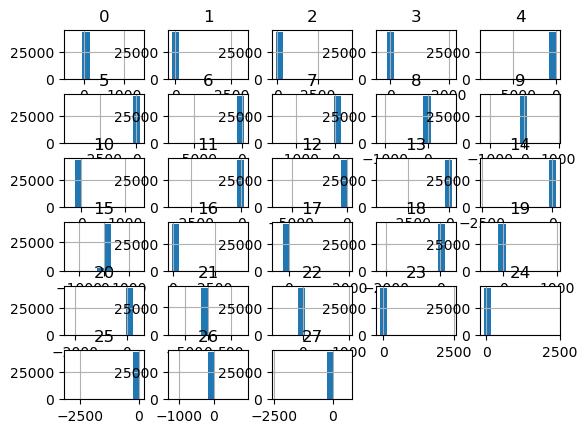

In [178]:
res.hist()

In [182]:
lgb_reg.evals_result_

In [165]:
submit_val = forecast_horizon_pred[['id']]
for i in range(28):
    submit_val['F'+str(i+1)] = forecast_horizon_pred['d_'+str(1914+i)]
submit_val['id'] =  submit_val['id'].apply(lambda x: x.replace('evaluation','validation'))
submit_eval = submit_val.copy()
submit_eval["id"] = submit_eval["id"].apply(lambda x: x.replace('validation','evaluation'))
submit_custom_ensemble = submit_val.append(submit_eval).reset_index(drop=True)

In [166]:
submit_custom_ensemble.to_csv("submit_custom_ensemble.csv", index=False)

In [168]:
pip install prettytable

Note: you may need to restart the kernel to use updated packages.


In [169]:
from prettytable import PrettyTable
res = PrettyTable()
res.field_names = ["Model", "WRMSSE"]
res.add_row(["Mean sales for the past 4 weeks of that dayofweek", 0.7524])
res.add_row(["Moving Average", 1.0567])
res.add_row(["RandomForestRegressor",0.7487])
res.add_row(["LgbmRegressor", 0.6087])
res.add_row(["SGDRegressor", 0.9682])
res.add_row(["AdaBoostRegressor", 0.7944])
res.add_row(["Custom_ensemble(num of base-models = 10)", 0.7988])
print(res)

+---------------------------------------------------+--------+
|                       Model                       | WRMSSE |
+---------------------------------------------------+--------+
| Mean sales for the past 4 weeks of that dayofweek | 0.7524 |
|                   Moving AVerage                  | 1.0567 |
|               RandomForestRegressor               | 0.7487 |
|                   LgbmRegressor                   | 0.6087 |
|                    SGDRegressor                   | 0.9682 |
|                 AdaBoostRegressor                 | 0.7944 |
|      Custom_ensemble(num of base-models = 10)     | 0.7988 |
+---------------------------------------------------+--------+
